In [2]:
from datetime import datetime
from os import environ
from os.path import join

import requests
import json

input_folder = environ.get(
    'CROSSCOMPUTE_INPUT_FOLDER', 'batches/standard/input')
output_folder = environ.get(
    'CROSSCOMPUTE_OUTPUT_FOLDER', 'batches/standard/output')

input_path = join(input_folder, 'variables.dictionary')
output_path = join(output_folder, 'variables.dictionary')
chart_output_path = join(output_folder, 'cost_chart.png')

value_by_key = json.load(open(input_path, 'rt'))

In [3]:
def limit_value(value, left_limit, right_limit):
    if value < left_limit:
        return left_limit
    if value > right_limit:
        return right_limit
    return value

In [4]:
BASE_URL = "https://archive-api.open-meteo.com/v1/archive"
PREVIOUS_YEAR = datetime.now().year - 1

LATITUDE = limit_value(value_by_key["latitude"], -90, 90)
LONGITUDE = limit_value(value_by_key["longitude"], -180, 180)
COST = limit_value(value_by_key["cost"], 0, 1000) / 24

PARAMETERS = {
  "latitude": LATITUDE,
  "longitude": LONGITUDE,
  "start_date": f"{PREVIOUS_YEAR}-01-01",
  "end_date": f"{PREVIOUS_YEAR}-12-31",
  "hourly": "temperature_2m"  
}

parameters = "&".join([f"{key}={value}" for key, value in PARAMETERS.items()])
URL = f"{BASE_URL}?{parameters}"

In [5]:
response = requests.get(URL)

# if response.status_code != 200:
data = response.json()

In [6]:
import pandas as pd

regions_summary = {}

df = pd.DataFrame.from_dict(data['hourly'])
df

,time,temperature_2m
0,2022-01-01T00:00,19.8
1,2022-01-01T01:00,17.7
2,2022-01-01T02:00,15.7
3,2022-01-01T03:00,13.6
4,2022-01-01T04:00,12.0
...,...,...
8755,2022-12-31T19:00,19.1
8756,2022-12-31T20:00,19.1
8757,2022-12-31T21:00,19.2
8758,2022-12-31T22:00,17.5


## Heating degree days (HDD) 

> Heating degree days (HDD) are a measure of how cold the temperature was on a given day or during a period of days. For example, a day with a mean temperature of 40°F has 25 HDD. Two such cold days in a row have a total of 50 HDD for the two-day period.


## Cooling degree days (CDD)
> Cooling degree days (CDD) are a measure of how hot the temperature was on a given day or during a period of days. A day with a mean temperature of 80°F has 15 CDD. If the next day has a mean temperature of 83°F, it has 18 CDD. The total CDD for the two days is 33 CDD.



- https://www.eia.gov/energyexplained/units-and-calculators/degree-days.php
- https://www.investopedia.com/terms/h/heatingdegreeday.asp
- https://www.investopedia.com/terms/c/colddegreeday.asp

In [7]:
df["time"] =  pd.to_datetime(df["time"])
df["HDD"] = 18.3333 - df["temperature_2m"]
df["CDD"] = df["temperature_2m"] - 18.3333

df.HDD[df["HDD"] < 0] = 0
df.CDD[df["CDD"] < 0] = 0


df["HDD_COST"] = df.HDD * COST
df["CDD_COST"] = df.CDD * COST

df

/tmp/ipykernel_21610/287210402.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.HDD[df["HDD"] < 0] = 0
/tmp/ipykernel_21610/287210402.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.CDD[df["CDD"] < 0] = 0


,time,temperature_2m,HDD,CDD,HDD_COST,CDD_COST
0,2022-01-01 00:00:00,19.8,0.0000,1.4667,0.000000,1.222250
1,2022-01-01 01:00:00,17.7,0.6333,0.0000,0.527750,0.000000
2,2022-01-01 02:00:00,15.7,2.6333,0.0000,2.194417,0.000000
3,2022-01-01 03:00:00,13.6,4.7333,0.0000,3.944417,0.000000
4,2022-01-01 04:00:00,12.0,6.3333,0.0000,5.277750,0.000000
...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,19.1,0.0000,0.7667,0.000000,0.638917
8756,2022-12-31 20:00:00,19.1,0.0000,0.7667,0.000000,0.638917
8757,2022-12-31 21:00:00,19.2,0.0000,0.8667,0.000000,0.722250
8758,2022-12-31 22:00:00,17.5,0.8333,0.0000,0.694417,0.000000


In [8]:
# Group data by months
months_summary = {}

for month_number in range(1, 52):
    month_data = df[df['time'].dt.isocalendar().week == month_number]
    total_hours = len(month_data)
    month_summary = {
        "total_hours": total_hours,
        "temperature": month_data["temperature_2m"].sum() / total_hours,
        "HDD": month_data["HDD"].sum() / 24,
        "CDD": month_data["CDD"].sum() / 24,
        "HDD_COST": month_data["HDD_COST"].sum(),
        "CDD_COST": month_data["CDD_COST"].sum(),
    }
    months_summary[month_number] = month_summary
    

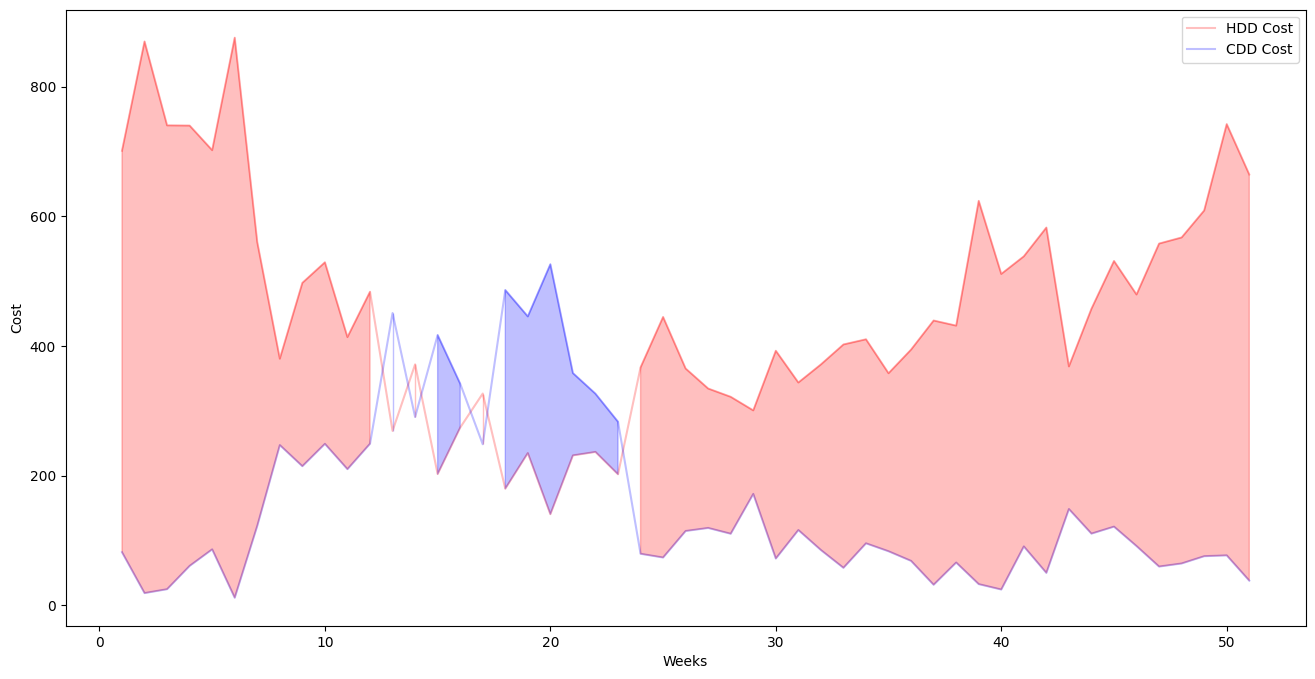

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(16, 8))

temperature = [month['temperature'] for month in months_summary.values()]
HDD = [month['HDD'] for month in months_summary.values()]
CDD = [month['CDD'] for month in months_summary.values()]
HDD_COST = [month['HDD_COST'] for month in months_summary.values()]
CDD_COST = [month['CDD_COST'] for month in months_summary.values()]

#ax.plot(months_summary.keys(), temperature, label = "Temperature")
#ax.plot(months_summary.keys(), HDD, label = "Heating degree days (HDD)", linestyle="--", color="red", alpha=0.5, )
ax.plot(months_summary.keys(), HDD_COST, label = "HDD Cost", linestyle="-", color="red", alpha=0.25, )

#ax.plot(months_summary.keys(), CDD, label = "Cooling degree days (CDD)", linestyle="--", color="blue", alpha=0.5, )
ax.plot(months_summary.keys(), CDD_COST, label = "CDD Cost", linestyle="-", color="blue", alpha=0.25, )

# Fill area when income > expenses with green
ax.fill_between(
    list(months_summary.keys()), HDD_COST, CDD_COST, where=np.array(HDD_COST) > np.array(CDD_COST), 
    interpolate=False, color="red", alpha=0.25, 
)

# Fill area when income <= expenses with red
ax.fill_between(
    list(months_summary.keys()), HDD_COST, CDD_COST, where=np.array(HDD_COST) <= np.array(CDD_COST), 
    interpolate=False, color="blue", alpha=0.25,
)

ax.legend()

plt.ylabel("Cost")
plt.xlabel("Weeks")

plt.savefig(chart_output_path)
plt.show()

In [17]:
value_by_key = {
  "summary": {
        "HDD": sum([month['HDD'] for month in months_summary.values()]),
        "CDD": sum([month['CDD'] for month in months_summary.values()]),
        "HDD_COST": sum([month['HDD_COST'] for month in months_summary.values()]),
        "CDD_COST": sum([month['CDD_COST'] for month in months_summary.values()]),
  }
}

json.dump(value_by_key, open(output_path, 'wt'), indent=4)
value_by_key

{'summary': {'HDD': 1153.5295791666667,
  'CDD': 404.0414791666664,
  'HDD_COST': 23070.591583333342,
  'CDD_COST': 8080.829583333332}}